<a href="https://colab.research.google.com/github/ipeirotis-org/datasets/blob/main/Restaurant_Inspections/DOH_Restaurant_Inspections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www1.nyc.gov/site/doh/business/food-operators/the-inspection-process.page

See https://www1.nyc.gov/assets/doh/downloads/pdf/rii/blue-book.pdf

In [1]:
!pip install -q google-cloud-secret-manager

from google.colab import auth
auth.authenticate_user()

from google.cloud import secretmanager

def access_secret_version(project_id, secret_id, version_id):
    """
    Access the payload of the given secret version and return it.

    Args:
        project_id (str): Google Cloud project ID.
        secret_id (str): ID of the secret to access.
        version_id (str): ID of the version to access.
    Returns:
        str: The secret version's payload, or None if
        the version does not exist.
    """
    client = secretmanager.SecretManagerServiceClient()
    name = f"projects/{project_id}/secrets/{secret_id}/versions/{version_id}"
    response = client.access_secret_version(request={"name": name})
    return response.payload.data.decode("UTF-8")


mysql_pass = access_secret_version("nyu-datasets", "MYSQL_PASSWORD", "latest")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.1/217.1 kB 3.1 MB/s eta 0:00:00


## Download Latest Dataset

In [2]:
!curl 'https://data.cityofnewyork.us/api/views/43nn-pn8j/rows.csv?accessType=DOWNLOAD' -o restaurants.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  121M    0  121M    0     0  6590k      0 --:--:--  0:00:18 --:--:-- 7134k


In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv("restaurants.csv", dtype = 'object')

In [4]:
initial_size = len(df)
initial_size

284531

In [5]:
# Render our plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
df.dtypes

,0
CAMIS,object
DBA,object
BORO,object
BUILDING,object
STREET,object
ZIPCODE,object
PHONE,object
CUISINE DESCRIPTION,object
INSPECTION DATE,object
ACTION,object


In [7]:
# Adding underscores in all column names
cols = df.columns
cols = cols.map(lambda x: x.replace(' ', '_').upper())
df.columns = cols

In [8]:
df.dtypes

,0
CAMIS,object
DBA,object
BORO,object
BUILDING,object
STREET,object
ZIPCODE,object
PHONE,object
CUISINE_DESCRIPTION,object
INSPECTION_DATE,object
ACTION,object


In [9]:
df.drop('LOCATION_POINT1', axis=1, inplace=True)

## Cleaning Individual Columns

In [10]:
df.CAMIS.isnull().sum()

np.int64(0)

In [11]:
df.DBA.isnull().sum()

np.int64(4)

In [12]:
# Checks that all CAMIS values correpond to a unique DBA value
# ie the same CAMIS always has the same DBA
max_cardinality = df[['DBA','CAMIS']].pivot_table(
    index='CAMIS',
    values='DBA',
    aggfunc=pd.Series.nunique
).DBA.max()

assert(max_cardinality==1)

### INSPECTION_TYPE

In [13]:
df.INSPECTION_TYPE.value_counts()

,count
INSPECTION_TYPE,
Cycle Inspection / Initial Inspection,151654
Cycle Inspection / Re-inspection,55754
Pre-permit (Operational) / Initial Inspection,39785
Pre-permit (Operational) / Re-inspection,10705
Administrative Miscellaneous / Initial Inspection,8092
Pre-permit (Non-operational) / Initial Inspection,3602
Cycle Inspection / Reopening Inspection,2678
Pre-permit (Operational) / Compliance Inspection,1979
Administrative Miscellaneous / Re-inspection,1654


In [14]:
sum(df.INSPECTION_TYPE.isnull())

3104

In [15]:
# We create a column "TO_DELETE" to mark the entries that we are not interested in.
# We will perform first the inspection/analysis on all the attributes, and then delete the rows

# Drop all cases where inspection is NULL
df['TO_DELETE'] = df.INSPECTION_TYPE.isnull()

In [16]:
sum(df['TO_DELETE'])

3104

In [17]:
# Break INSPECTION_TYPE into two columns, and also delete some inspection types

# Create a new column that contains the results of the split on the '/'' character
lst = df.INSPECTION_TYPE.str.split(' / ').values.tolist()
lst = [ l if type(l)==type(list()) else ['',''] for l in lst ]
t = pd.DataFrame(lst)


In [18]:
t[0].value_counts()

,count
0,
Cycle Inspection,211413
Pre-permit (Operational),53461
Administrative Miscellaneous,9978
Pre-permit (Non-operational),4007
,3104
Inter-Agency Task Force,701
Smoke-Free Air Act,690
Trans Fat,567
Calorie Posting,500


In [19]:
t[1].value_counts()

,count
1,
Initial Inspection,205471
Re-inspection,68665
Reopening Inspection,3511
Compliance Inspection,3438
,3104
Second Compliance Inspection,341
Limited Inspection,1


In [20]:
# Keep only cycle inspections. Ignore admin, pre-permit, transfat, and calorie posting inspections
# We will only keep the initial inspections and the re-inspections. The other types are border cases

keep = df.INSPECTION_TYPE.isin( ['Cycle Inspection / Initial Inspection', 'Cycle Inspection / Re-inspection'])


In [21]:
# Check how many we will drop: ~keep means negation on the keep and summing up adds up the 'True'
sum(~keep)

77123

In [22]:
# Adding the "not keep" entries into the TO_DELETE

# The |= operator is a shortcut for df['TO_DELETE'] = df['TO_DELETE'] | ~keep
# We use the bit-OR operator (|), as we want to keep the existing deletions, and add the ones from the
# additional condition
df['TO_DELETE'] |= ~keep

In [23]:
# Rename the two entries that we will keep into simpler values

df["INSPECTION_TYPE"].replace(
    to_replace='Cycle Inspection / Initial Inspection',
    value = 'Initial Inspection',
    inplace=True
)
df["INSPECTION_TYPE"].replace(
    to_replace='Cycle Inspection / Re-inspection',
    value = 'Re-inspection',
    inplace=True
)

<ipython-input-23-5ad52777e638>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["INSPECTION_TYPE"].replace(
<ipython-input-23-5ad52777e638>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col:

In [24]:
sum(df['TO_DELETE'])

77123

### BORO

In [25]:
df.BORO.value_counts()

,count
BORO,
Manhattan,105091
Brooklyn,74700
Queens,68791
Bronx,25922
Staten Island,10011
0,16


In [26]:
sum(df.BORO.isnull())

0

In [ ]:
# Replace the "Missing" in BORO with null
# df.BORO = df.BORO.replace('Missing', np.NaN)

In [27]:
missing = set(df[df.BORO.isnull()].CAMIS)
# missing

In [28]:
sum(df.BORO == '0')

16

In [29]:
# Remove the entries with null/missing BORO value
# Not worth trying to fix.
df['TO_DELETE'] |= (df.BORO == '0')

In [30]:
sum(df['TO_DELETE'])

77123

### BUILDING

In [31]:
sum(df.BUILDING.isnull())

324

In [32]:
# Inspect the entries with missing street number
# df[df.BUILDING.isnull()]

In [33]:
# Dropping the violations listed without street number
# Most are in train stations and in airports, but there
# are a few others in 'regular' locations

df['TO_DELETE'] |= df.BUILDING.isnull()

In [34]:
sum(df['TO_DELETE'])

77357

### STREET

In [35]:
# Check that no street values are empty
sum(df.STREET.isnull())

5

In [36]:
df['TO_DELETE'] |= df.STREET.isnull()

In [37]:
sum(df['TO_DELETE'])

77357

### ZIPCODE

In [38]:
sum(df.ZIPCODE.isnull())

2822

In [39]:
len(set(df[df.ZIPCODE.isnull()].CAMIS))

425

In [40]:
df['TO_DELETE'] |= df.ZIPCODE.isnull()

In [ ]:
# TODO: Fill in the missing zip codes, perhaps with geocoding of the addresses
# For now, we just drop the cases without ZIPCODE

### CUISINE DESCRIPTION

In [41]:
df.CUISINE_DESCRIPTION.value_counts()

,count
CUISINE_DESCRIPTION,
American,45206
Chinese,27449
Coffee/Tea,20035
Pizza,17226
Latin American,12209
...,...
Chilean,32
Czech,13
Haute Cuisine,5


In [42]:
len(df.CUISINE_DESCRIPTION.value_counts())

89

In [43]:
sum(df.CUISINE_DESCRIPTION.isnull())

3104

In [ ]:
'''
df.CUISINE_DESCRIPTION.replace(
    to_replace='Café/Coffee/Tea',
    value = 'Cafe',
    inplace=True
)

df.CUISINE_DESCRIPTION.replace(
    to_replace='Latin (Cuban, Dominican, Puerto Rican, South & Central American)',
    value = 'Latin',
    inplace=True
)
'''

"\ndf.CUISINE_DESCRIPTION.replace(\n    to_replace='Café/Coffee/Tea',\n    value = 'Cafe',\n    inplace=True\n)\n\ndf.CUISINE_DESCRIPTION.replace(\n    to_replace='Latin (Cuban, Dominican, Puerto Rican, South & Central American)',\n    value = 'Latin',\n    inplace=True\n)\n"

### INSPECTION_DATE

In [44]:
df["INSPECTION_DATE"] = pd.to_datetime(df["INSPECTION_DATE"], format="%m/%d/%Y")

In [45]:
df.INSPECTION_DATE.describe()

,INSPECTION_DATE
count,284531
mean,2022-05-20 14:10:28.444703744
min,1900-01-01 00:00:00
25%,2022-11-15 00:00:00
50%,2023-10-31 00:00:00
75%,2024-09-13 00:00:00
max,2025-05-31 00:00:00


In [46]:
sum(df.INSPECTION_DATE.isnull())

0

<Axes: >

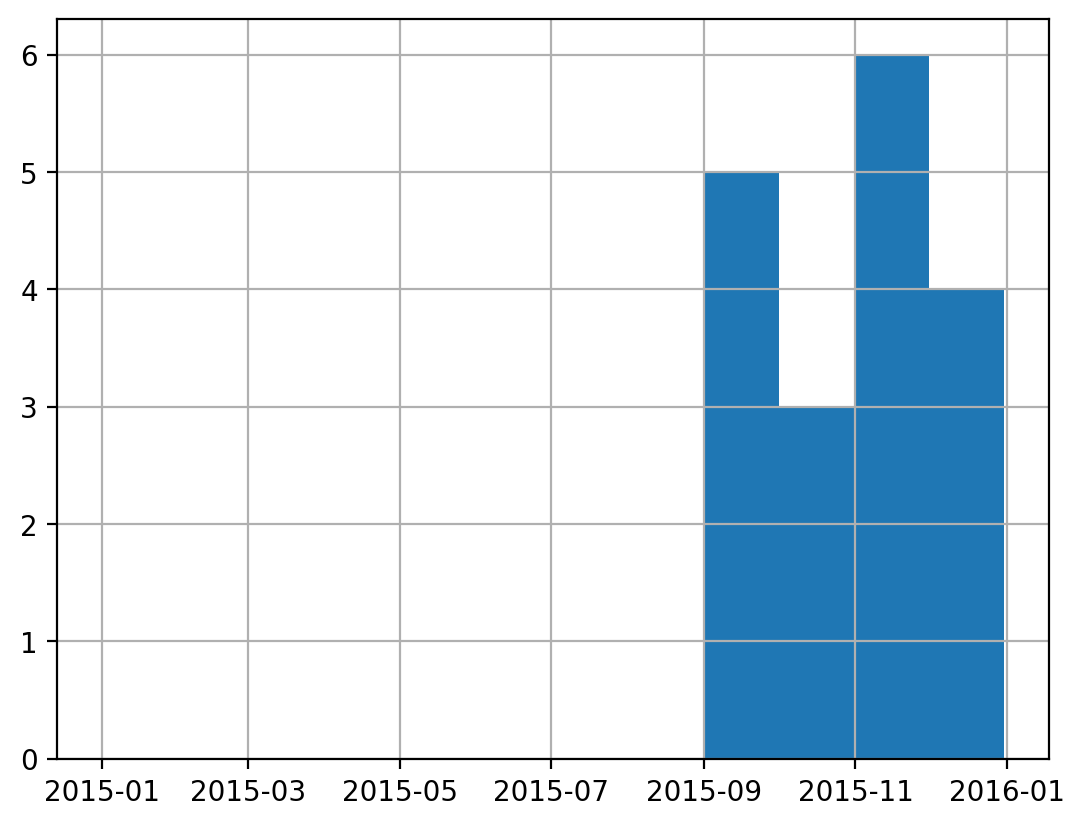

In [49]:
df.INSPECTION_DATE.hist(range=(pd.to_datetime('2015-01-01'),pd.to_datetime('2015-12-31')), bins=12)

In [48]:
# Drop the 1900-01-01 inspections. These are all incorrect and we cannot fix them
df['TO_DELETE'] |= (df['INSPECTION_DATE'] == '1900-01-01')

In [50]:
# After analysis, it seems that we have minimal number of inspections before 2016
df['TO_DELETE'] |=  (df['INSPECTION_DATE'] < '2016-01-01')

In [51]:
sum(df['TO_DELETE'])

79623

### ACTION

In [52]:
sum(df.ACTION.isnull())

3104

In [53]:
df["ACTION"].value_counts()

,count
ACTION,
Violations were cited in the following area(s).,266728
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.,9617
No violations were recorded at the time of this inspection.,1952
Establishment re-opened by DOHMH.,1923
Establishment re-closed by DOHMH.,1207


In [54]:
df["ACTION"].replace(
    to_replace='Violations were cited in the following area(s).',
    value = 'Violations found',
    inplace=True
)

<ipython-input-54-d6b4ee601f3d>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["ACTION"].replace(


In [55]:
df["ACTION"].replace(
    to_replace='No violations were recorded at the time of this inspection.',
    value = 'No violations',
    inplace=True
)

<ipython-input-55-b17d2c7ffb4a>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["ACTION"].replace(


In [56]:
df["ACTION"].replace(
    to_replace='Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.',
    value = 'Establishment closed',
    inplace=True
)

<ipython-input-56-237dd0bf2637>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["ACTION"].replace(


In [57]:
df["ACTION"].replace(
    to_replace='Establishment re-opened by DOHMH.',
    value = 'Establishment re-opened',
    inplace=True
)

<ipython-input-57-743dc084ed30>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["ACTION"].replace(


In [58]:
df["ACTION"].replace(
    to_replace='Establishment re-closed by DOHMH.',
    value = 'Establishment re-closed',
    inplace=True
)

<ipython-input-58-e1988b6427a8>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["ACTION"].replace(


In [59]:
df["ACTION"].value_counts()

,count
ACTION,
Violations found,266728
Establishment closed,9617
No violations,1952
Establishment re-opened,1923
Establishment re-closed,1207


In [60]:
# Drop the Establishment re-opened and re-closed cases
# as the inspection scores for these can be misleading
df['TO_DELETE'] |=  (df.ACTION == 'Establishment re-closed')
df['TO_DELETE'] |=  (df.ACTION == 'Establishment re-opened')
df['TO_DELETE'] |=  df.ACTION.isnull()

In [61]:
sum(df['TO_DELETE'])

79623

### SCORE

In [62]:
df["SCORE"] = pd.to_numeric(df["SCORE"])

In [63]:
df.SCORE.describe()

,SCORE
count,269582.000000
mean,24.342100
std,18.263795
min,0.000000
25%,12.000000
50%,21.000000
75%,32.000000
max,168.000000


In [64]:
len(df)

284531

In [65]:
len( df[ df.SCORE < 0 ] )

0

In [66]:
df['TO_DELETE'] |= (df.SCORE < 0)

In [67]:
sum(df['TO_DELETE'])

79623

In [68]:
# Drop cases reported as "no violations but with positive score"
df['TO_DELETE'] |= ((df.SCORE > 0)  & (df.ACTION == 'No violations'))

# Drop cases with zero score but with violations found
df['TO_DELETE'] |= ((df.SCORE == 0)  & (df.ACTION == 'Violations found'))

In [69]:
# Drop incorrectly scored inspections
df['TO_DELETE'] |=  (df.GRADE=='A') & (df.SCORE>13)

df['TO_DELETE'] |=  (df.GRADE=='B') & ( (df.SCORE<14) | (df.SCORE>27) )

# Drop incorrectly scored inspections
df['TO_DELETE'] |=  (df.GRADE=='C') & (df.SCORE<28)


In [70]:
sum(df['TO_DELETE'])

85335

### RECORD_DATE

In [71]:
df["RECORD_DATE"] = pd.to_datetime(df["RECORD_DATE"], format="%m/%d/%Y")

In [72]:
# Drop record date field, as it only contains a single value
df = df.drop( 'RECORD_DATE', axis = 'columns')

### GRADE

In [73]:
df.GRADE.value_counts()

,count
GRADE,
A,95038
B,16876
C,11262
N,9032
Z,5486
P,920


In [74]:
sum(df.GRADE.isnull())

145917

In [ ]:
df.query(" GRADE == 'N' ")

In [ ]:
# P assigned to 'Establishment re-opened' actions
df.query(" GRADE == 'P' ")

In [ ]:
# P assigned to 'Establishment re-opened' actions
df.query(" GRADE == 'P' ").ACTION.value_counts()

ACTION
Establishment re-opened    671
Name: count, dtype: int64

In [ ]:
# P assigned to 'Reopening Inspection' inspection types
df.query(" GRADE == 'P' ").INSPECTION_TYPE.value_counts()

INSPECTION_TYPE
Cycle Inspection / Reopening Inspection            487
Pre-permit (Operational) / Reopening Inspection    184
Name: count, dtype: int64

In [ ]:
# df.query(" GRADE == 'Z' ").SCORE.hist(bins=100)

In [ ]:
# TODO: Figure out what Z, and Not Yet Graded means in GRADE
# Until then, we just replace these values with NULL, keeping only the A, B, C grades

#
df.GRADE.value_counts()

GRADE
A    78428
B    13210
N     8407
C     7839
Z     4909
P      671
Name: count, dtype: int64

In [78]:
df['TO_DELETE'] |=  (df.GRADE=='Z')
df['TO_DELETE'] |=  (df.GRADE=='P')
df['TO_DELETE'] |=  (df.GRADE=='N') # Not Yet Graded
df['TO_DELETE'] |=  (df.GRADE=='Not Yet Graded')

### GRADE_DATE

In [79]:
df["GRADE_DATE"] = pd.to_datetime(df["GRADE_DATE"], format="%m/%d/%Y")


In [80]:
# Grade date and inspection date should be the same.
assert np.abs((df.GRADE_DATE - df.INSPECTION_DATE).dropna()).sum().days == 0

In [81]:
# Check that is there is a grade date, a grade is also assigned
assert sum ( ~df.GRADE_DATE.isnull() & df.GRADE.isnull() )  == 0

In [82]:
# We do not need GRADE DATE if we have INSPECTION DATE
df = df.drop("GRADE_DATE", axis='columns')

### VIOLATION_CODE and VIOLATION_DESCRIPTION

In [83]:
df.VIOLATION_CODE.isnull().sum()

np.int64(5035)

In [84]:
# All the cases where violation code is NULL should be either cases that we delete
# or a "No violations" case
check = df[df.VIOLATION_CODE.isnull() & ~df.TO_DELETE & (df.ACTION!='No violations')]

assert( len(check) == 0 )


In [85]:
df.VIOLATION_DESCRIPTION.isnull().sum()

np.int64(5035)

In [86]:
# Checks that all VIOLATION_CODE has unique VIOLATION_DESCRIPTION
df[['VIOLATION_CODE','VIOLATION_DESCRIPTION']].drop_duplicates().pivot_table(
    index='VIOLATION_CODE',
    values='VIOLATION_DESCRIPTION',
    aggfunc=pd.Series.nunique
).sort_values('VIOLATION_DESCRIPTION', ascending=False).head(20)

,VIOLATION_DESCRIPTION
VIOLATION_CODE,
05C,4
06A,4
06C,4
02C,3
02A,3
04D,3
03E,3
05H,3
05D,3


In [ ]:
df['TO_DELETE'] |=  (df.VIOLATION_DESCRIPTION == 'Caloric content not posted on menus, menu boards or food tags, in a food service establishment that is 1 of 15 or more outlets operating the same type of business nationally under common ownership or control, or as a franchise or doing business under the same name, for each menu item that is served in portions, the size and content of which are standardized.')

In [ ]:
# In the dataset we have a NULL violation, when there is no violation
# To make this more explicit, we replace NULL with 000
# df.VIOLATION_CODE.fillna('000', inplace=True)

In [87]:
df.VIOLATION_CODE.isnull().sum()

np.int64(5035)

In [ ]:
## LATITUDE and LONGITUDE

In [88]:
df['LONGITUDE'] = pd.to_numeric(df['LONGITUDE'])
df['LATITUDE'] = pd.to_numeric(df['LATITUDE'])

### MISC analysis

In [89]:
# Find the unique values in each column
#
# df.describe(include = [np.object, 'category']).T['unique']
unique = df.describe(include = 'all').T['unique'].sort_values()

for column in unique.index:
    if unique[column] < 200:
        print(df[column].value_counts())
        print("=====")

TO_DELETE
False    193529
True      91002
Name: count, dtype: int64
=====
CRITICAL_FLAG
Critical          151603
Not Critical      126161
Not Applicable      6767
Name: count, dtype: int64
=====
ACTION
Violations found           266728
Establishment closed         9617
No violations                1952
Establishment re-opened      1923
Establishment re-closed      1207
Name: count, dtype: int64
=====
BORO
Manhattan        105091
Brooklyn          74700
Queens            68791
Bronx             25922
Staten Island     10011
0                    16
Name: count, dtype: int64
=====
GRADE
A    95038
B    16876
C    11262
N     9032
Z     5486
P      920
Name: count, dtype: int64
=====
INSPECTION_TYPE
Initial Inspection                                             151654
Re-inspection                                                   55754
Pre-permit (Operational) / Initial Inspection                   39785
Pre-permit (Operational) / Re-inspection                        10705
Administrative 

In [90]:
df.dtypes

,0
CAMIS,object
DBA,object
BORO,object
BUILDING,object
STREET,object
ZIPCODE,object
PHONE,object
CUISINE_DESCRIPTION,object
INSPECTION_DATE,datetime64[ns]
ACTION,object


## Deleting Entries

In this section, we use the results of the analysis above, and delete (additional) entries that will not be useful in our analysis. (Note that it is important to document this, as others may want to go back to the original source, if the entries that we leave are not sufficient.)

In [91]:
len(df)

284531

In [92]:
assert len(df) == initial_size

In [93]:
df = df[ df.TO_DELETE == False].copy()

In [94]:
len(df)

193529

In [95]:
df[df.VIOLATION_CODE.isnull()].VIOLATION_DESCRIPTION

,VIOLATION_DESCRIPTION
3,NaN
349,NaN
365,NaN
394,NaN
407,NaN
...,...
278787,NaN
279393,NaN
280394,NaN
281177,NaN


## Additional Data Quality Checks

In [96]:


assert sum(df.INSPECTION_TYPE.isnull()) == 0

assert len(set(df.INSPECTION_TYPE.values)) == 2

df["INSPECTION_TYPE"] =  pd.Categorical(df["INSPECTION_TYPE"], ordered=False)

In [97]:
# Check that no borough entries are empty
assert sum(df.BORO.isnull()) == 0

df["BORO"] =  pd.Categorical(df["BORO"], ordered=False)

In [98]:
# Check that no street numbers are empty
assert sum(df.BUILDING.isnull()) == 0

In [99]:
assert sum(df.STREET.isnull()) == 0

In [100]:

assert sum(df.CUISINE_DESCRIPTION.isnull()) == 0

df["CUISINE_DESCRIPTION"] =  pd.Categorical(df["CUISINE_DESCRIPTION"], ordered=False)

In [101]:
# We only keep three different actions
assert len(set(df.ACTION.values)) == 3

# No action is empty
assert sum(df.ACTION.isnull()) == 0

df["ACTION"] =  pd.Categorical(df["ACTION"], ordered=False)

In [102]:
# The below drops any grade values other than A, B, C, and converts the remaining entries to null
df["GRADE"] =  pd.Categorical(df["GRADE"], categories = ['A', 'B', 'C'], ordered=True)

# https://www1.nyc.gov/assets/doh/downloads/pdf/rii/how-we-score-grade.pdf
# 0-13 get an A
assert sum( (df.GRADE=='A') & (df.SCORE>13)) == 0

# 14-27 get a B
assert sum( (df.GRADE=='B') & ( (df.SCORE<14) | (df.SCORE>27) ) ) == 0

# 28- get a C
assert sum( (df.GRADE=='C') & (df.SCORE<28) ) == 0

# TODO: In principle, a NULL grade is only when the score is above 14, and it was an initial inspection

In [ ]:
# Check that is there is a grade date, a grade is also assigned
# assert sum ( ~df.GRADE_DATE.isnull() & df.GRADE.isnull() ) == 0

In [103]:
df["VIOLATION_CODE"] =  pd.Categorical(df["VIOLATION_CODE"], ordered=False)
df["CRITICAL_FLAG"] =  pd.Categorical(df["CRITICAL_FLAG"], ordered=False)


In [104]:
df [ df.VIOLATION_CODE.isnull() ].VIOLATION_DESCRIPTION

,VIOLATION_DESCRIPTION
3,NaN
349,NaN
365,NaN
394,NaN
407,NaN
...,...
278787,NaN
279393,NaN
280394,NaN
281177,NaN


## Normalization

### Violation Codes

In [105]:
# Recreating the table at https://www1.nyc.gov/assets/doh/downloads/pdf/rii/ri-violation-penalty.pdf

violation_codes = df [ ['VIOLATION_CODE', 'VIOLATION_DESCRIPTION', 'CRITICAL_FLAG'] ].drop_duplicates()
violation_codes = violation_codes.rename( {
    'VIOLATION_DESCRIPTION' : 'DESCRIPTION',
    'CRITICAL_FLAG' : 'CRITICAL'
},  axis = 'columns').sort_values('VIOLATION_CODE').dropna().set_index('VIOLATION_CODE')
violation_codes

,DESCRIPTION,CRITICAL
VIOLATION_CODE,,
02A,Food not cooked to required minimum temperature.,Critical
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02B,Hot TCS food item not held at or above 140 °F.,Critical
02B,Hot food item not held at or above 140º F.,Critical
...,...,...
28-05,Food adulterated or misbranded. Adulterated or...,Not Critical
28-05,Food adulterated or misbranded. Adulterated o...,Not Critical
28-06,Contract with a pest management professional n...,Not Critical


In [ ]:
violation_codes

,DESCRIPTION,CRITICAL
VIOLATION_CODE,,
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02A,Food not cooked to required minimum temperature.,Critical
02B,Hot TCS food item not held at or above 140 °F.,Critical
02B,Hot food item not held at or above 140º F.,Critical
...,...,...
28-05,Food adulterated or misbranded. Adulterated or...,Not Critical
28-05,Food adulterated or misbranded. Adulterated o...,Not Critical
28-06,Contract with a pest management professional n...,Not Critical


In [106]:
# Drop the description and critical part from the main dataframe
df = df.drop(['VIOLATION_DESCRIPTION' ,  'CRITICAL_FLAG'], axis='columns')

In [107]:
df

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE
3,50091872,DOMINO'S,Bronx,3869,WHITE PLAINS ROAD,10467,7186534618,Pizza,2022-10-18,No violations,...,Initial Inspection,40.885262,-73.861884,212,12,039400,2057657,2046560039,BX44,False
17,41719692,GOOD FELLAS PIZZA,Queens,2519,40 AVENUE,11101,7184721932,Pizza,2022-07-22,Violations found,...,Initial Inspection,40.753421,-73.937811,401,26,003300,4004794,4003960037,QN68,False
26,50070541,LE BOTANISTE,Manhattan,127,GRAND STREET,10013,3478044095,Vegan,2022-03-23,Violations found,...,Initial Inspection,40.720594,-74.000213,102,01,004500,1003035,1002320013,MN24,False
29,50058614,BA SAK CHICKEN,Queens,17107,NORTHERN BLVD,11358,7183538484,Korean,2024-10-10,Violations found,...,Initial Inspection,40.757996,-73.795515,407,19,117500,4438198,4053500001,QN51,False
32,41454244,COSTA VERDE,Queens,9459,CORONA AVENUE,11373,7182710900,Peruvian,2023-05-11,Violations found,...,Re-inspection,40.742303,-73.869482,404,25,046100,4314507,4016040154,QN29,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284526,41503140,VIP COFFEE,Brooklyn,6714,BAY PARKWAY,11204,7188378388,Bakery Products/Desserts,2023-02-28,Violations found,...,Re-inspection,40.612372,-73.982982,311,47,025600,3134805,3055720037,BK28,False
284527,50035797,NO.1 CHINESE RESTAURANT,Queens,6308,BROADWAY,11377,7185075023,Chinese,2022-12-06,Violations found,...,Re-inspection,40.749930,-73.899098,402,26,026100,4027522,4012030056,QN63,False
284528,50110168,BROOKLYN WAFFLE HOUSE,Brooklyn,434,HANCOCK STREET,11233,3476624810,Pancakes/Waffles,2023-12-22,Violations found,...,Initial Inspection,40.683891,-73.938099,303,36,027500,3045995,3016590003,BK35,False
284529,40744131,ANTOJITOS MEXICANOS,Brooklyn,107,GRAHAM AVENUE,11206,7183849076,Mexican,2024-09-19,Violations found,...,Initial Inspection,40.705402,-73.942898,301,34,050500,3071344,3030790026,BK90,False


### Restaurants

In [108]:
df.columns.values

array(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE_DESCRIPTION', 'INSPECTION_DATE', 'ACTION',
       'VIOLATION_CODE', 'SCORE', 'GRADE', 'INSPECTION_TYPE', 'LATITUDE',
       'LONGITUDE', 'COMMUNITY_BOARD', 'COUNCIL_DISTRICT', 'CENSUS_TRACT',
       'BIN', 'BBL', 'NTA', 'TO_DELETE'], dtype=object)

In [109]:
columns = ['CAMIS', 'DBA', 'BUILDING', 'STREET', 'ZIPCODE', 'BORO', 'PHONE',
           'CUISINE_DESCRIPTION', 'LATITUDE', 'LONGITUDE',
       'COMMUNITY_BOARD', 'COUNCIL_DISTRICT', 'CENSUS_TRACT', 'BIN',
       'BBL', 'NTA']
restaurants =  df [ columns ].drop_duplicates()

In [110]:
# Check that we have the same attributes for a given CAMIS
# and the we do not have duplicate CAMIS values
assert len(restaurants) == len(set(restaurants.CAMIS.values))

In [111]:
restaurants.head(5)

,CAMIS,DBA,BUILDING,STREET,ZIPCODE,BORO,PHONE,CUISINE_DESCRIPTION,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA
3,50091872,DOMINO'S,3869,WHITE PLAINS ROAD,10467,Bronx,7186534618,Pizza,40.885262,-73.861884,212,12,039400,2057657,2046560039,BX44
17,41719692,GOOD FELLAS PIZZA,2519,40 AVENUE,11101,Queens,7184721932,Pizza,40.753421,-73.937811,401,26,003300,4004794,4003960037,QN68
26,50070541,LE BOTANISTE,127,GRAND STREET,10013,Manhattan,3478044095,Vegan,40.720594,-74.000213,102,01,004500,1003035,1002320013,MN24
29,50058614,BA SAK CHICKEN,17107,NORTHERN BLVD,11358,Queens,7183538484,Korean,40.757996,-73.795515,407,19,117500,4438198,4053500001,QN51
32,41454244,COSTA VERDE,9459,CORONA AVENUE,11373,Queens,7182710900,Peruvian,40.742303,-73.869482,404,25,046100,4314507,4016040154,QN29


In [112]:
restaurants.PHONE.value_counts().head(20)

,count
PHONE,
2124656273,43
2126159700,26
9172843260,25
9176186310,24
2125867610,18
6143187413,15
9175103862,14
2124656302,14
2122441111,14


In [ ]:
# __ = restaurants.PHONE.value_counts().head(10).index.values[7]

In [ ]:
# restaurants.PHONE.replace(to_replace=__, value=np.nan, inplace=True)

In [ ]:
# Citi Field concessions
# restaurants.query("PHONE == '7185958100'").head(5)

In [ ]:
# Madison Square Garden concession stands
# restaurants.query("PHONE == '2124656273'").head(5)

In [ ]:
# restaurants.plot(kind='scatter', x='LONGITUDE', y='LATITUDE', alpha=0.2, s=1, figsize=(15,15))

In [113]:
df = df.drop (columns[1:], axis='columns')

In [114]:
df

,CAMIS,INSPECTION_DATE,ACTION,VIOLATION_CODE,SCORE,GRADE,INSPECTION_TYPE,TO_DELETE
3,50091872,2022-10-18,No violations,NaN,0.0,A,Initial Inspection,False
17,41719692,2022-07-22,Violations found,02B,22.0,NaN,Initial Inspection,False
26,50070541,2022-03-23,Violations found,02B,13.0,A,Initial Inspection,False
29,50058614,2024-10-10,Violations found,09B,7.0,A,Initial Inspection,False
32,41454244,2023-05-11,Violations found,09B,11.0,A,Re-inspection,False
...,...,...,...,...,...,...,...,...
284526,41503140,2023-02-28,Violations found,08A,24.0,B,Re-inspection,False
284527,50035797,2022-12-06,Violations found,08A,16.0,B,Re-inspection,False
284528,50110168,2023-12-22,Violations found,02G,13.0,A,Initial Inspection,False
284529,40744131,2024-09-19,Violations found,06C,58.0,NaN,Initial Inspection,False


### Inspections

In [115]:
# Each inspection has multiple violations. We want to keep just the inspections for now
inspection = df.drop('VIOLATION_CODE', axis='columns').drop_duplicates().sort_values(['INSPECTION_DATE', 'CAMIS'])

In [116]:
inspection

,CAMIS,INSPECTION_DATE,ACTION,SCORE,GRADE,INSPECTION_TYPE,TO_DELETE
7495,50041177,2016-01-21,Violations found,6.0,A,Initial Inspection,False
13353,41627984,2016-02-14,Violations found,19.0,NaN,Initial Inspection,False
61845,41589635,2016-03-11,Violations found,9.0,A,Initial Inspection,False
195091,41611709,2016-03-26,Violations found,13.0,A,Re-inspection,False
33709,50003174,2016-04-01,Violations found,29.0,NaN,Initial Inspection,False
...,...,...,...,...,...,...,...
160318,50144824,2025-05-30,Violations found,5.0,A,Initial Inspection,False
47681,50146171,2025-05-30,Violations found,26.0,NaN,Initial Inspection,False
136684,50146175,2025-05-30,Violations found,8.0,A,Initial Inspection,False
156980,50146678,2025-05-30,Violations found,2.0,A,Initial Inspection,False


In [117]:
# We create an ID for each inspection here
inspection = inspection.reset_index().drop('index', axis='columns').reset_index().rename({'index': 'INSPECTION_ID'}, axis='columns')

In [118]:
inspection.ACTION.value_counts()

,count
ACTION,
Violations found,58097
Establishment closed,905
No violations,382


In [119]:
# Ensure that the inspection table contains
# no duplicate pairs for 'INSPECTION_DATE', 'CAMIS'
pvt = inspection.pivot_table(
    index = ['INSPECTION_DATE', 'CAMIS'],
    values = 'INSPECTION_ID',
    aggfunc = 'count'
)
pvt [ pvt.INSPECTION_ID > 1 ]

# assert len(pvt [ pvt.INSPECTION_ID > 1 ]) == 0

,,INSPECTION_ID
INSPECTION_DATE,CAMIS,
2017-11-04,40911114,2


In [120]:
# df[ (df.CAMIS =='41007054') & (df.INSPECTION_DATE == '2017-03-03')  ].sort_values('VIOLATION_CODE')

In [ ]:
# to_drop = inspection.query(" CAMIS =='50051092' and  INSPECTION_DATE == '2019-09-11' ").index.values[1]
# inspection = inspection.drop(to_drop, axis='index')

In [121]:
to_drop = inspection.query(" CAMIS =='40911114' and  INSPECTION_DATE == '2017-11-04' ").index.values[1]

inspection = inspection.drop(to_drop, axis='index')

<ipython-input-121-38f2eeae63ca>:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  to_drop = inspection.query(" CAMIS =='40911114' and  INSPECTION_DATE == '2017-11-04' ").index.values[1]


In [122]:
inspection.drop('TO_DELETE', axis='columns', inplace=True)

In [123]:
# Ensure that the inspection table contains
# no duplicate pairs for 'INSPECTION_DATE', 'CAMIS'
pvt = inspection.pivot_table(
    index = ['INSPECTION_DATE', 'CAMIS'],
    values = 'INSPECTION_ID',
    aggfunc = 'count'
)
assert len(pvt [ pvt.INSPECTION_ID > 1 ]) == 0

In [124]:
inspection.INSPECTION_TYPE.value_counts()

,count
INSPECTION_TYPE,
Initial Inspection,43470
Re-inspection,15913


In [125]:
inspection_stats = inspection.pivot_table(
    index = 'CAMIS',
    aggfunc = ['min', 'max', 'count'],
    values = 'INSPECTION_DATE'
)

<Axes: xlabel='INSPECTION_DATE'>

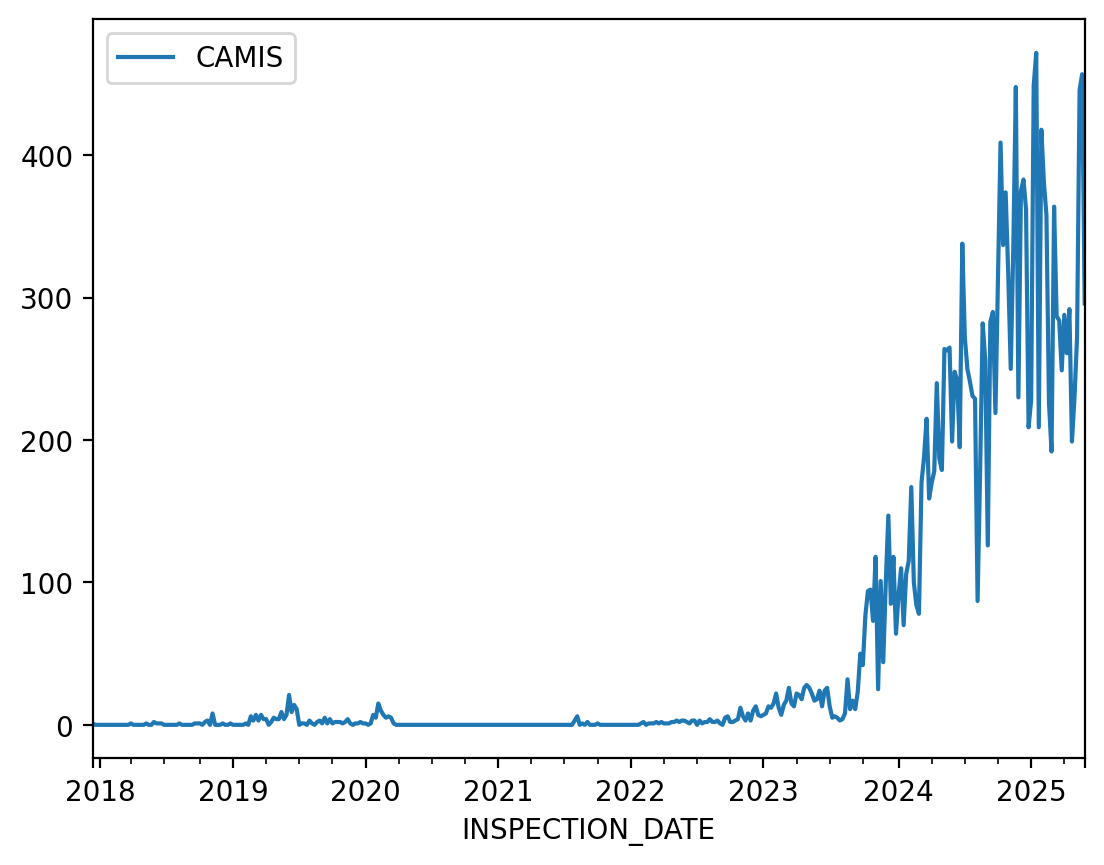

In [126]:
# Distribution of last inspection across all restaurants
inspection_stats['max'].sort_values('INSPECTION_DATE').reset_index().pivot_table(
    index='INSPECTION_DATE',
    aggfunc='count'
).resample('1W').sum().plot()

In [ ]:
# Longevity
# (inspection_stats['max'] - inspection_stats['min'])['INSPECTION DATE'].sort_values()

<Axes: xlabel='INSPECTION_DATE'>

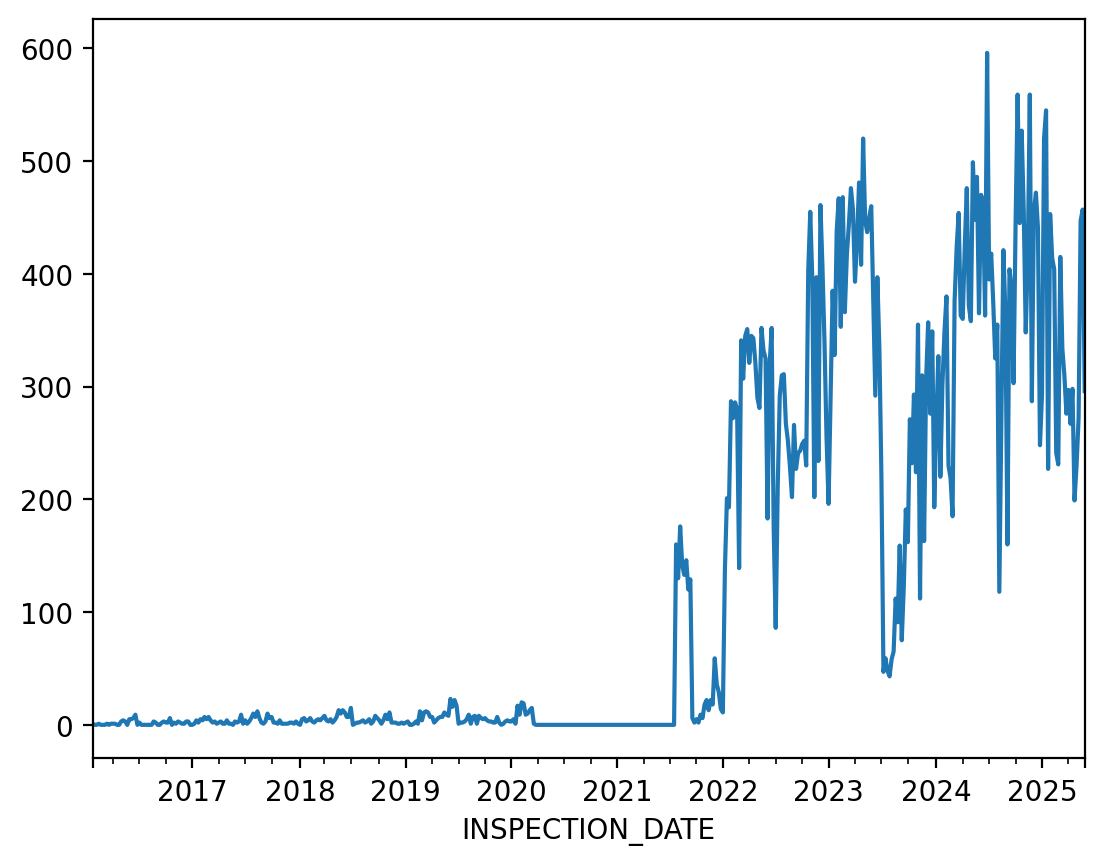

In [127]:
# Distribution of all inspections
inspection['INSPECTION_DATE'].value_counts().sort_index().resample('1W').sum().plot()

In [128]:
len(df)

193529

In [129]:
violations = pd.merge(
    inspection,
    df[ ['CAMIS', 'INSPECTION_DATE', 'VIOLATION_CODE' ] ],
    on= ['CAMIS', 'INSPECTION_DATE'],
    how = 'inner'
)
violations = violations[ ['INSPECTION_ID', 'VIOLATION_CODE'] ].drop_duplicates()
len(violations)

193525

In [130]:
print(f"Violations: {len(violations)}")
print(f"Inspections: {len(inspection)}")
print(f"Restaurants: {len(restaurants)}")
print(f"Violation Codes: {len(violation_codes)}")

Violations: 193525
Inspections: 59383
Restaurants: 21022
Violation Codes: 149


## Storing in MySQL


In [132]:
!sudo pip3 install -U -q PyMySQL sqlalchemy sql_magic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.8 MB/s eta 0:00:00


In [133]:
import os
from sqlalchemy import create_engine
from sqlalchemy import text

conn_string = 'mysql+pymysql://{user}:{password}@{host}/?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org',
    user = 'root',
    password = mysql_pass,
    encoding = 'utf8mb4')

engine = create_engine(conn_string)
con = engine.connect()

In [149]:
# Query to create a database
db_name = 'doh_restaurants'

sql = f"DROP DATABASE IF EXISTS {db_name}"
with engine.connect() as connection:
  connection.execute(text(sql))

# Create a database
sql = f"CREATE DATABASE IF NOT EXISTS {db_name} DEFAULT CHARACTER SET 'utf8mb4'"
with engine.connect() as connection:
  connection.execute(text(sql))

# And lets switch to the database
sql = f"USE {db_name}"
with engine.connect() as connection:
  connection.execute(text(sql))

In [150]:
create_table_sql = '''
CREATE TABLE restaurants (
    CAMIS                      char(8),
    DBA varchar(100),
    BUILDING varchar(10),
    STREET varchar(40),
    ZIPCODE char(5),
    BORO ENUM('Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island')  ,
    PHONE char(10),
    CUISINE_DESCRIPTION    varchar(30),
LATITUDE                float,
LONGITUDE               float,
COMMUNITY_BOARD          char(3),
COUNCIL_DISTRICT         char(2),
CENSUS_TRACT             char(6),
BIN                      char(7),
BBL                      char(10),
NTA                      char(4),
PRIMARY KEY(CAMIS)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as connection:
  connection.execute(text(create_table_sql))


create_table_sql = '''
CREATE TABLE inspections (
    INSPECTION_ID               char(8),
    CAMIS                      char(8),
    INSPECTION_DATE    datetime,
    ACTION                   ENUM('Violations found','Establishment closed','No violations'),
    SCORE                     smallint,
    GRADE                    char(1),
    INSPECTION_TYPE          ENUM('Initial Inspection','Re-inspection'),
    FOREIGN KEY(CAMIS) REFERENCES restaurants(CAMIS),
    PRIMARY KEY(INSPECTION_ID)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as connection:
  connection.execute(text(create_table_sql))

create_table_sql = '''
CREATE TABLE violation_codes (
  VIOLATION_CODE     char(5),
  DESCRIPTION varchar(1000),
  CRITICAL ENUM('Critical', 'Not Applicable', 'Not Critical'),
  PRIMARY KEY(VIOLATION_CODE)

) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as connection:
  connection.execute(text(create_table_sql))


create_table_sql = '''
CREATE TABLE violations (
  INSPECTION_ID         char(8),
  VIOLATION_CODE     char(5),
  FOREIGN KEY(INSPECTION_ID) REFERENCES inspections(INSPECTION_ID)
  -- FOREIGN KEY(VIOLATION_CODE) REFERENCES violation_codes(VIOLATION_CODE)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as connection:
  connection.execute(text(create_table_sql))

In [151]:
violation_codes.reset_index().VIOLATION_CODE.str.len().max()

5

In [152]:
violation_codes

,DESCRIPTION,CRITICAL
VIOLATION_CODE,,
02A,Food not cooked to required minimum temperature.,Critical
02B,Hot TCS food item not held at or above 140 °F.,Critical
02C,Hot TCS food item that has been cooked and coo...,Critical
02D,Precooked potentially hazardous food from comm...,Critical
02F,"Meat, fish or molluscan shellfish served raw o...",Critical
...,...,...
22F,MISBRANDED AND LABELING,Not Critical
22G,Sale or use of certain expanded polystyrene it...,Not Critical
28-05,Food adulterated or misbranded. Adulterated or...,Not Critical


In [153]:
violation_codes = violation_codes.groupby('VIOLATION_CODE').first()

<ipython-input-153-5527dd98b9ff>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  violation_codes = violation_codes.groupby('VIOLATION_CODE').first()


In [154]:
violation_codes.reset_index().to_sql(
        name = 'violation_codes',
        schema = db_name,
        con = engine,
        if_exists = 'append',
        index = False,
        chunksize = 1000)

72

In [147]:
restaurants["PHONE"].replace(
    to_replace='19292290938',
    value = '9292290938',
    inplace=True
)

In [155]:
restaurants.to_sql(
        name = 'restaurants',
        schema = db_name,
        con = engine,
        if_exists = 'append',
        index = False,
        chunksize = 1000)

21022

In [156]:
inspection.to_sql(
        name = 'inspections',
        schema = db_name,
        con = engine,
        if_exists = 'append',
        index = False,
        chunksize = 1000)

59383

In [157]:
violations.to_sql(
        name = 'violations',
        schema = db_name,
        con = engine,
        if_exists = 'append',
        index = False,
        chunksize = 1000)

193525

In [158]:
sql = '''
GRANT SELECT ON doh_restaurants.* TO 'student'@'%'
'''
with engine.connect() as connection:
  connection.execute(text(sql))

In [159]:


sql = '''
CREATE VIEW restaurant_inspection_latest AS
	WITH latest_inspection AS (
		SELECT CAMIS, MAX(INSPECTION_DATE) AS INSPECTION_DATE FROM inspections
		GROUP BY CAMIS
	)
	SELECT R.CAMIS, R.DBA, R.BUILDING, R.STREET, R.ZIPCODE, R.BORO, R.CUISINE_DESCRIPTION, R.LATITUDE, R.LONGITUDE, I.INSPECTION_DATE, I.INSPECTION_ID, I.INSPECTION_TYPE, V.VIOLATION_CODE, I.SCORE, I.GRADE
		FROM restaurants R
			JOIN latest_inspection L ON R.CAMIS = L.CAMIS
			JOIN inspections I ON I.CAMIS = L.CAMIS AND L.INSPECTION_DATE = I.INSPECTION_DATE
			JOIN violations V ON I.INSPECTION_ID = V.INSPECTION_ID
      '''

with engine.connect() as connection:
  connection.execute(text(sql))